<a href="https://colab.research.google.com/github/ccosmin97/idc-prostate-mri-analysis/blob/main/cancer_bundle_train_prostate158.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PC Segmentation bundle : minimum working example 

PLEASE RUN CELL BY CELL -- NOT MEANT TO BE RUN IN ONE GO

This notebook demonstrates the application of the creation of PC bundle applied to the pre-trained model training data, prostate158.

Environment setup, data organization and inference only is showcased below.

The baseline bundle was previously created in [Monal Model Zoo -- prostate mri anatomy bundle](https://github.com/Project-MONAI/model-zoo/tree/dev/models/prostate_mri_anatomy), showcasing results of [Prostate158 - An expert-annotated 3T MRI dataset and algorithm for prostate cancer detection](https://www.sciencedirect.com/science/article/abs/pii/S0010482522005789?via%3Dihub#kwrds0010) by **Lisa C.Adams**.

Here is their offical [github repository](https://github.com/kbressem/prostate158) by **Keno Bressem**. 

The prostate cancer segmentation bundle we created took the available U-Net model pre-trained weights given by the authors and prostate158 training data.
Pre-trained weights are available [here](https://doi.org/10.5281/zenodo.6397057).

Please see [this zenodo link](https://zenodo.org/record/6481141#.Y-FWa-zMLBs) for requesting access to prostate158 training data.

The changes being made compared to prostate mri anatomy bundle was the modification of metadata.json and inference.json, mostly changing input and output channels of the model(PC segmentation model has 2 output channels(background and tumor) and 3 input channels(T2, ADC, DWI).

Details about the input modalities and data pre-processing can be found in the paper mentioned above.


## Setup -- Restart runtime after execution of this setup section

**Setup of packages needed**

Installing monai dependencies and simpleitk, pyyaml, munch, pandas

Conflict with google colab packages -- installing specific versions of protobuf -- need to restart runtime

Rest of commented out packages are needed if dealing with DCM data or resampling needs for evaluation : 



*   DCM conversion to NIFTI format and sorting by DCM attributes
  
  * dcmqi
  * dcm2niix
  * dicomsort

*   Resampling
  
  * pyplastimatch
  * plastimatch

* Visualization

  * itkwidgets



In [ ]:
!pip install simpleitk
!pip install -U "monai[all]" pyyaml munch pandas

In [57]:
%%capture
!sudo apt update
# !sudo apt install plastimatch
!sudo apt install subversion
# PyPlastimatch - paython wrapper for Plastimatch (and interactive notebook visualisation)
# !svn checkout https://github.com/AIM-Harvard/pyplastimatch/trunk/pyplastimatch pyplastimatch

In [ ]:
!pip install protobuf==3.9.2
!pip install grpcio
!pip install grpcio-tools
!pip install google-cloud-bigquery
# !pip install pydicom
# !pip install nibabel
# !pip install dcm2niix

In [59]:
# dicomsort is the pythong package that can sort DICOM files into
# folder organization based on user-specified DICOM attributes
# !git clone https://github.com/pieper/dicomsort.git

In [60]:
# %%capture
# !wget https://github.com/QIICR/dcmqi/releases/download/v1.2.5/dcmqi-1.2.5-linux.tar.gz 
# !tar zxvf dcmqi-1.2.5-linux.tar.gz
# !cp dcmqi-1.2.5-linux/bin/* /usr/local/bin/

In [61]:
# !pip install 'itkwidgets>=1.0a16'

## Monai setup and imports

Download PC segmentation bundle from github

In [ ]:
!svn checkout https://github.com/ImagingDataCommons/idc-prostate-mri-analysis.git/trunk/pcDetectionBundle/ monai_pcdetection_bundle

Imports

In [2]:
# from pyplastimatch import pyplastimatch as pypla
# from pyplastimatch.utils import viz as viz_utils
# from pyplastimatch.utils import data as data_utils
# import nibabel as nib
# import pandas as pd
# import pydicom
# import nibabel as nib
# from scipy import ndimage
import numpy as np
import glob
import json
import os

Colab imports

In [3]:
#colab 
from google.colab import auth
auth.authenticate_user()

To use the bundle on our own data, we need to modify the inference.json file, also included in the bundle.

The variables that we need to modify are the locations of the **data, model and output** directories paths.

## Setup of working directory for inference

In [4]:
# !rm -rf monai_pcdetection_bundle

Definition of inference paths in our local environment, later used to overwite downloaded inference.json file

In [5]:
#Definition of paths
os.environ["monai_workspace"] = "monai_pcdetection_bundle"
os.environ["monai_workspace_eval"] = os.path.join(os.environ["monai_workspace"], "eval/")
os.environ["monai_workspace_dataset"] = os.path.join(os.environ["monai_workspace"], "dataset/")
os.environ["monai_workspace_model_dir"] = os.path.join(os.environ["monai_workspace"], "models")
os.environ["monai_workspace_model_path"] = os.path.join(os.environ["monai_workspace"], "models", "cancer.pt")

In [6]:
#Make sure these folders exists, otherwise created
!mkdir -p {os.environ["monai_workspace"]}
!mkdir -p {os.environ["monai_workspace_eval"]}
!mkdir -p {os.environ["monai_workspace_dataset"]}
!mkdir -p {os.environ["monai_workspace_model_dir"]}

Download pre-trained PC model to local model path : bundle/models/placeholder.pt 

In [7]:
!gsutil -m cp -r gs://projectweek38/pcdetection/models/cancer.pt {os.environ["monai_workspace_model_dir"]}/cancer.pt
# !wget https://zenodo.org/record/6397057/files/tumor.pt?download=1 -O {os.environ["monai_workspace_model_dir"]}/cancer.pt

Copying gs://projectweek38/pcdetection/models/cancer.pt...
-
Operation completed over 1 objects/145.7 MiB.                                    


Copy prostate158 training data as an input for inference pipeline

Here is a look at the data downloaded :

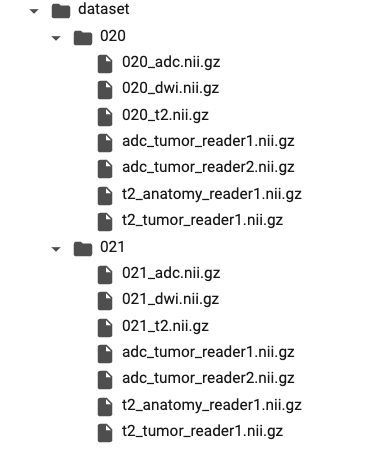

In [ ]:
!gsutil -m cp -r gs://projectweek38/pcdetection/data/prostate158/* {os.environ["monai_workspace_dataset"]}/

Since we are dealing with multi-modality input data([t2,adc,dwi]), monai bundle expects a certain format :


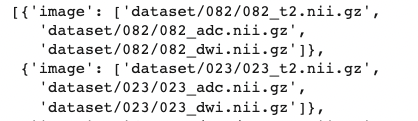

Please also keep in mind that the loading method used here needs relative paths to the bundle root folder to work properly, not absolute paths.

On another note, during inference, writing to disk of the model ouputs only takes into account the file name, so please make sure your input nifti samples have different naming, even across modalities of the same sample, convention used here is caseID_modality.nii.gz

The pipeline below showcases :

input_nifti_data_paths 

**-->** 

```
[[caseID1_t2.nii.gz, caseID1_adc.nii.gz, caseID1_dwi.nii.gz],

[caseID2_t2.nii.gz, caseID2_adc.nii.gz, caseID2_dwi.nii.gz],...]
```

**-->** dump to json : datalist.json


This datalist.json is later loaded in the inference.json and looks like this :



```
{"testing" : [relative_path/caseID1_t2.nii.gz, relative_path/caseID1_adc.nii.gz, relative_pathcaseID1_dwi.nii.gz],

[relative_path/caseID2_t2.nii.gz, relative_path/caseID2_adc.nii.gz, relative_path/caseID2_dwi.nii.gz],...}
```




In [9]:
eval_lst = []
for folder in glob.glob(os.path.join(os.environ["monai_workspace_dataset"], "*")):
  patID = folder.split('/')[-1]
  eval_lst.append([os.path.join('/'.join(folder.split('/')[-2:]), patID+"_t2.nii.gz"), 
                   os.path.join('/'.join(folder.split('/')[-2:]), patID+"_adc.nii.gz"), 
                   os.path.join('/'.join(folder.split('/')[-2:]), patID+"_dwi.nii.gz")])
  # rename files to include patID in filename -- avoid monai inference file saving overwriting
  !mv  {os.path.join(folder, "t2.nii.gz")}  {os.path.join(folder, patID+"_t2.nii.gz")}
  !mv  {os.path.join(folder, "adc.nii.gz")}  {os.path.join(folder, patID+"_adc.nii.gz")}
  !mv  {os.path.join(folder, "dwi.nii.gz")}  {os.path.join(folder, patID+"_dwi.nii.gz")}

In [10]:
for index, item in enumerate(eval_lst) :
  eval_lst[index]={"image" : item}
with open(os.path.join(os.environ["monai_workspace"],'datalist.json'), 'w') as fp:
  json.dump({"testing" : eval_lst}, fp)

Setup of inference.json parameters

In [11]:
inference_json = json.load(open(os.environ["monai_workspace"]+"/configs/inference.json"))
#setup variables
inference_json["bundle_root"] = os.environ["monai_workspace"]
inference_json["output_dir"] = os.environ["monai_workspace_eval"]
inference_json["dataset_dir"] = os.environ["monai_workspace_dataset"]
inference_json["handlers"][0]["load_path"] = os.environ["monai_workspace_model_path"]
inference_json["test_datalist"] = "$monai.data.load_decathlon_datalist('/content/monai_pcdetection_bundle/datalist.json', data_list_key='testing')"

Overriding of inference.json to local workspace

In [12]:
with open(os.environ["monai_workspace"]+'/configs/inference.json', 'w') as fp:
    json.dump(inference_json, fp, indent=4)

## Inference

Inference using monai bundle -- metadata.json provided from monai bundle, no change needed

In [ ]:
!python -m monai.bundle run evaluating --meta_file /content/monai_pcdetection_bundle/configs/metadata.json --config_file /content/monai_pcdetection_bundle/configs/inference.json 

Upload to google buckets

In [ ]:
!gsutil -m cp -r /content/monai_workspace/eval/**/*.nii.gz gs://projectweek38/pcdetection/cancer_preds_prostate158_train/